In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import math
import os

import pytesseract
from pytesseract import Output
from sklearn.cluster import KMeans
from random import randint

In [2]:
# Helper functions

# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45 :
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

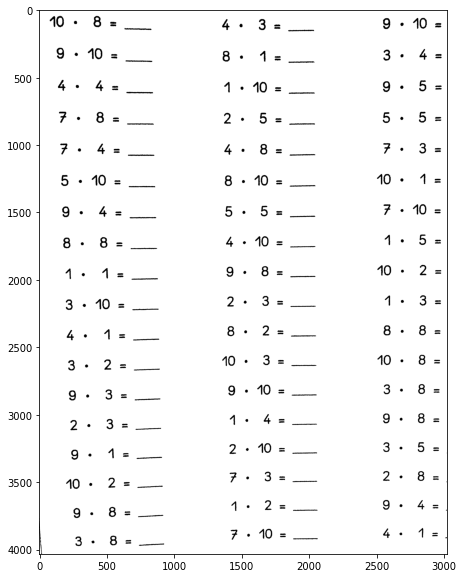

In [3]:
# Read and preprocess image

image = cv2.imread('testImages/testImage1.jpg')
#image = cv2.imread('testImages/testImage2.jpg')
#image = cv2.imread('testImages/testImage3.jpg')
imageCopy = image.copy()


image = get_grayscale(image)
image = thresholding(image)
plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')

Number of found bounding boxes:  54


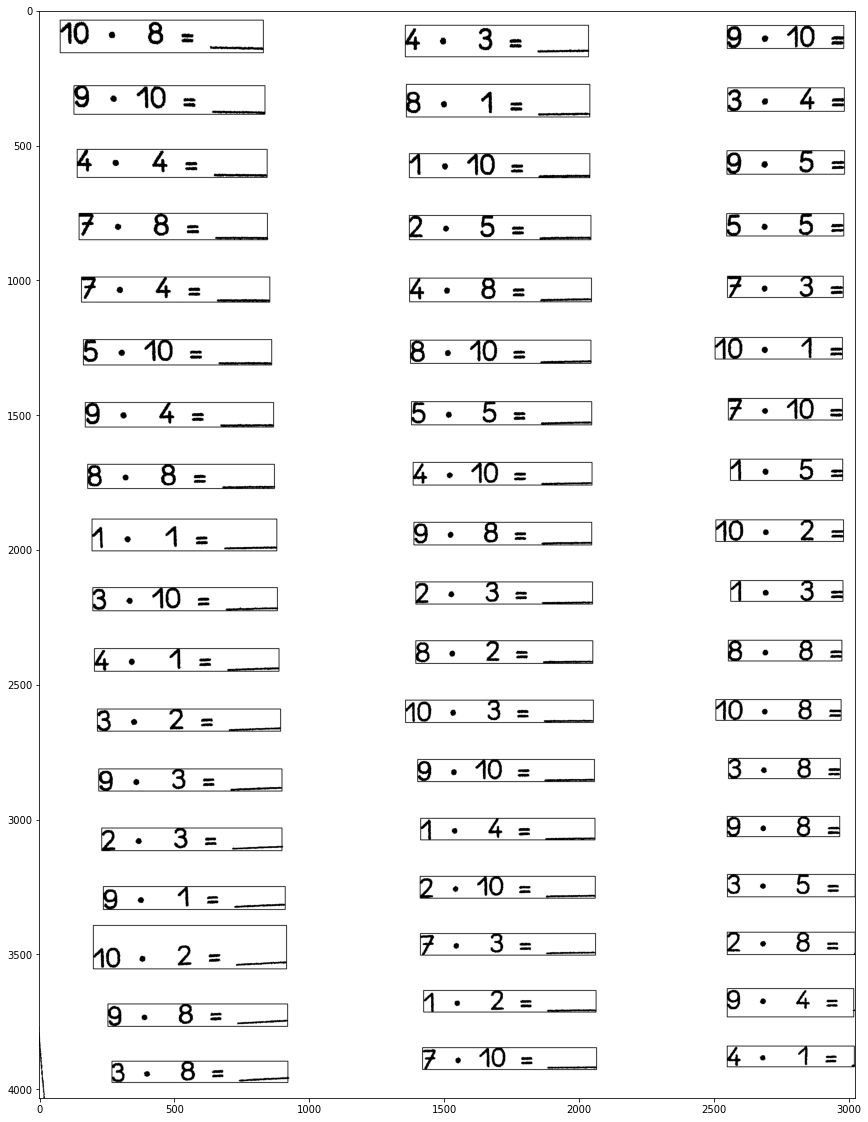

In [4]:
# Select preprocessed image and apply tesseract OCR 

img = image
custom_config = r'--oem 3 --psm 6 outputbase digits'
widthMax = 1000
heightMax = 1000
ratioMax =  1/10
areaMax = 1000*300
areaMin = 10*50

d = pytesseract.image_to_data(img, config=custom_config, output_type=Output.DICT)
n_boxes = len(d['level'])
boxList = []
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    #Check if the absolute lenght or hight is too high
    #Check if the ratio is too high
    #Check if the area is too high
    if (w < widthMax and h < heightMax and (h/w) > ratioMax and (h*w) > areaMin):
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        boxList.append((x, y, x + w, y + h))

# Plot results
print("Number of found bounding boxes: ", len(boxList))
plt.figure(figsize=(20,20))
plt.imshow(img, cmap = 'gray')

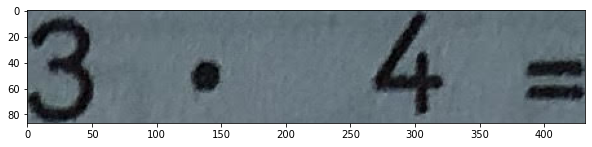

In [5]:
# Apply sublevel OCR to all found boxes

n = 5

# Extract box dimensions 
a = boxList[n][0]
b = boxList[n][1]
c = boxList[n][2]
d = boxList[n][3]
subImg = imageCopy[b:d,a:c]

# Plot bounding box
plt.figure(figsize=(10,10))
plt.imshow(subImg)

(4514, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


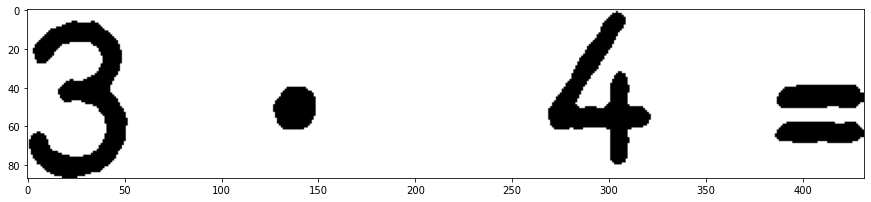

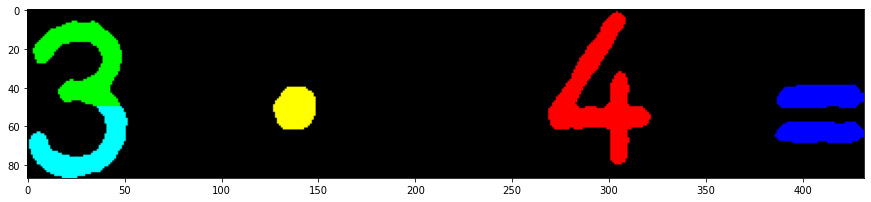

In [6]:
# Apply clustering to equation 

# Preprocessing
subImg = get_grayscale(subImg)
subImg = remove_noise(subImg)
subImg = thresholding(subImg)
#subImg = subImg / 255.0
#subImg = opening(subImg)
#subImg = canny(subImg)
#subImg = dilate(subImg)

length = subImg.shape[0]
width = subImg.shape[1]
plt.figure(figsize=(15,15))
plt.imshow(subImg, cmap="gray")

# Bring the above picuture into a clusterable format
pointList = []
for x in range(0, length): 
    for y in range(0, width):
        if subImg[x,y] < 100:
            pointList.append((x,y))
            
# Transform list into numpy Array
pointArray = np.array(pointList)     
print(pointArray.shape)

# K mean cluster algorithm
k_means =  KMeans(init="k-means++", n_clusters=5, n_init=100)
k_means.fit(pointArray)

# Plot results
colorMapList = [[255,0,0], [0,255,0], [0,0,255], [255,255,0], [0,255,255]]    
clusterImg = np.zeros((length,width,3))
clusterImg[:,:] = (0, 0, 0)
# Color code canny edge point with corresponding cluster label
for idx, (x, y) in enumerate(pointList): 
    clusterImg[x,y] = colorMapList[k_means.labels_[idx]]
# Plot figure
plt.figure(figsize=(15,15))
plt.imshow(clusterImg)